In [1]:
import os
import re
import json
from datetime import datetime
import pandas as pd

In [2]:
log_dir = r'C:\Users\Gebruiker\Desktop\pepperchat\Robotics_Project\logs'


In [3]:
# Prepare a dictionary to store data by user_id
data = {}

In [4]:
def process_json_entries(file_path):
    with open(file_path, 'r') as file:
        buffer = ""
        for line in file:
            buffer += line.strip()
            try:
                while buffer:
                    obj, idx = json.JSONDecoder().raw_decode(buffer)
                    yield obj
                    buffer = buffer[idx:].lstrip(',')
            except json.JSONDecodeError:
                continue  # Handle incomplete JSON data

In [5]:
for filename in os.listdir(log_dir):
    match = re.match(r'dialogue\.(\d+)\.2024-\d{2}-\d{2}_\d+', filename)
    if match:
        user_id = int(match.group(1))
        file_path = os.path.join(log_dir, filename)
        logs = process_json_entries(file_path)

        client_type = 'OaiClient' if 1 <= user_id <= 41 else 'TinyLlamaClient'

        for log_entry in logs:
            for key in ['sending', 'receiving']:
                if key in log_entry:
                    current_time = None
                    tokens = 0
                    if client_type == 'OaiClient' and 'time' in log_entry[key]:
                        current_time = datetime.fromisoformat(log_entry[key]['time'][:-3])
                    elif client_type == 'TinyLlamaClient' and key == 'receiving' and 'total_duration' in log_entry[key]:
                        current_time = datetime.fromisoformat(log_entry[key]['time'][:-3])
                    elif client_type == 'TinyLlamaClient' and key == 'sending' and 'time' in log_entry[key]:
                        current_time = datetime.fromisoformat(log_entry[key]['time'][:-3])

                    if current_time:
                        if user_id not in data:
                            data[user_id] = {
                                'client_type': client_type,
                                'questions_count': 0,
                                'total_response_time': 0,
                                'response_count': 0,
                                'total_tokens': 0,
                                'token_counts': [],
                                'first_message_time': current_time,
                                'last_message_time': current_time,
                                'question_times': []
                            }

                        data[user_id]['last_message_time'] = current_time

                        if key == 'sending' and 'input' in log_entry[key]:
                            data[user_id]['questions_count'] += 1
                            data[user_id]['question_times'].append(current_time)

                        if key == 'receiving':
                            if data[user_id]['question_times']:
                                question_time = data[user_id]['question_times'].pop(0)
                                response_time = (current_time - question_time).total_seconds()
                                data[user_id]['total_response_time'] += response_time
                                data[user_id]['response_count'] += 1

                            # Handle token counting for both client types
                            if client_type == 'OaiClient' and 'usage' in log_entry[key]:
                                tokens = log_entry[key]['usage'].get('total_tokens')
                            elif client_type == 'TinyLlamaClient' and 'eval_count' in log_entry[key]:
                                tokens = log_entry[key]['eval_count']

                            data[user_id]['total_tokens'] += tokens
                            data[user_id]['token_counts'].append(tokens)


In [6]:
data

{1: {'client_type': 'OaiClient',
  'questions_count': 6,
  'total_response_time': 6.835999999999999,
  'response_count': 6,
  'total_tokens': 907,
  'token_counts': [0, 0, 46, 84, 123, 159, 201, 294],
  'first_message_time': datetime.datetime(2024, 5, 8, 14, 20, 17, 103000),
  'last_message_time': datetime.datetime(2024, 5, 8, 14, 21, 38, 361000),
  'question_times': []},
 10: {'client_type': 'OaiClient',
  'questions_count': 11,
  'total_response_time': 13.489,
  'response_count': 11,
  'total_tokens': 4713,
  'token_counts': [0, 0, 81, 147, 211, 300, 386, 461, 505, 554, 610, 696, 762],
  'first_message_time': datetime.datetime(2024, 5, 8, 15, 37, 29, 822000),
  'last_message_time': datetime.datetime(2024, 5, 8, 15, 42, 44, 418000),
  'question_times': []},
 11: {'client_type': 'OaiClient',
  'questions_count': 11,
  'total_response_time': 15.378,
  'response_count': 11,
  'total_tokens': 4287,
  'token_counts': [0,
   0,
   0,
   0,
   52,
   122,
   201,
   272,
   351,
   434,
   4

In [7]:
user_data = []
for user_id, stats in data.items():
    avg_response_time = stats['total_response_time'] / max(1, stats['response_count'])
    conversation_length = (stats['last_message_time'] - stats['first_message_time']).total_seconds()
    mean_token_count = sum(stats['token_counts']) / max(1, len(stats['token_counts']))

    user_data.append({
        'user_id': user_id,
        'client_type': stats['client_type'],
        'questions_count': stats['questions_count'],
        'average_response_time': avg_response_time,
        'total_tokens': stats['total_tokens'],
        'mean_token_count': mean_token_count,
        'conversation_length_seconds': conversation_length
    })

df = pd.DataFrame(user_data)
print(df)






    user_id      client_type  questions_count  average_response_time  \
0         1        OaiClient                6               1.139333   
1        10        OaiClient               11               1.226273   
2        11        OaiClient               11               1.398000   
3        12        OaiClient                9               1.197889   
4        13        OaiClient                4               1.114750   
..      ...              ...              ...                    ...   
61       67  TinyLlamaClient               12               6.559364   
62       68  TinyLlamaClient                6               8.583167   
63        7        OaiClient               10               1.316400   
64        8        OaiClient                3               1.210667   
65        9        OaiClient                9               1.158889   

    total_tokens  mean_token_count  conversation_length_seconds  
0            907        113.375000                       81.258  
1  

In [8]:
# the ID's from OaiClient to TinyLlamaClient 
id_to_change = [38, 39, 40, 41]

# lets change the client_type from OaiClient to TinyLlamaClient 
df.loc[df['user_id'].isin(id_to_change), 'client_type'] = 'TinyLlamaClient'


In [9]:
df

,user_id,client_type,questions_count,average_response_time,total_tokens,mean_token_count,conversation_length_seconds
0,1,OaiClient,6,1.139333,907,113.375000,81.258
1,10,OaiClient,11,1.226273,4713,362.538462,314.596
2,11,OaiClient,11,1.398000,4287,285.800000,301.390
3,12,OaiClient,9,1.197889,2638,239.818182,150.858
4,13,OaiClient,4,1.114750,608,101.333333,113.463
...,...,...,...,...,...,...,...
61,67,TinyLlamaClient,12,6.559364,654,59.454545,0.028
62,68,TinyLlamaClient,6,8.583167,482,80.333333,0.025
63,7,OaiClient,10,1.316400,1201,66.722222,524.308
64,8,OaiClient,3,1.210667,351,70.200000,60.034


In [10]:
suervy = pd.read_excel(r'Data/Participant Feedback Survey on Human-Robot Interaction (HRI) -- Gpt version (Antwoorden) (1).xlsx')
suervy.columns = ['time', 'age','gender', 'type_of_person', 'education', 'tech_fimiliarity', 'intearction', 'smoothness', 'satisfaction', 'comment' , 'ID','type']

In [11]:
suervy['ID'] = suervy['ID'].astype('float64')

In [12]:
# lets split df between OpenAI and TinyLlama 
df_oai = df[df['client_type'] == 'OaiClient'] 
df_tiny = df[df['client_type'] == 'TinyLlamaClient'] 

In [13]:
# lets merge the two dataframes df_oai with suervy where user_id is ID within the survey
df_oai = df_oai.rename(columns={'user_id': 'ID'})
df_oai = df_oai.astype({'ID': 'float64'})
df_oai = pd.merge(df_oai, suervy, on='ID') 

df_tiny = df_tiny.rename(columns={'user_id': 'ID'})
df_tiny = df_tiny.astype({'ID': 'float64'})
df_tiny = pd.merge(df_tiny, suervy, on='ID')


In [14]:
# lets define a function to convert the smoothness and satisfaction to a scale of 1 to 5 
def convert_to_scale(x):
    if x == 'Very dissatisfied':
        return 1
    elif x == 'Dissatisfied':
        return 2
    elif x == 'Neutral':
        return 3
    elif x == 'Satisfied':
        return 4
    elif x == 'Very satisfied':
        return 5
    else:
        return 0

def convert_smoothness(x):
    if x == 'Very smooth':
        return 5
    elif x == 'Smooth':
        return 4
    elif x == 'Neutral':
        return 3
    elif x == 'Somewhat choppy':
        return 2
    elif x == 'very choppy':
        return 1
    else:
        return 0

In [15]:

# function that take the gender and make it a binary

df_oai['gender'] = df_oai['gender'].apply(lambda x: 1 if x == 'Male' else 0)
df_oai['type_of_person'] = df_oai['type_of_person'].apply(lambda x: 1 if x == 'Student' else 0)

df_oai['smoothness'] = df_oai['smoothness'].apply(convert_smoothness)
df_oai['satisfaction'] = df_oai['satisfaction'].apply(convert_to_scale) 



df_tiny['gender'] = df_tiny['gender'].apply(lambda x: 1 if x == 'Male' else 0)
df_tiny['type_of_person'] = df_tiny['type_of_person'].apply(lambda x: 1 if x == 'Student' else 0)

df_tiny['smoothness'] = df_tiny['smoothness'].apply(convert_smoothness)
df_tiny['satisfaction'] = df_tiny['satisfaction'].apply(convert_to_scale)



In [16]:
# lets do some Correlation analysis on the numerical data
# Select only numerical columns
df_oai_numerical = df_oai.select_dtypes(include=['number'])
# lets just dont take the ID column
df_oai_numerical = df_oai_numerical.drop(columns=['ID','type_of_person'])
df_oai_numerical = df_oai_numerical.apply(pd.to_numeric, errors='coerce')



# Select only numerical columns
df_tiny_numerical = df_tiny.select_dtypes(include=['number'])
# lets just dont take the ID column
df_tiny_numerical = df_tiny_numerical.drop(columns=['ID', 'type_of_person']) 
df_tiny_numerical = df_tiny_numerical.apply(pd.to_numeric, errors='coerce')



In [17]:
correlation_matrix_oai = df_oai_numerical.corr()
correlation_matrix_tiny = df_tiny_numerical.corr()


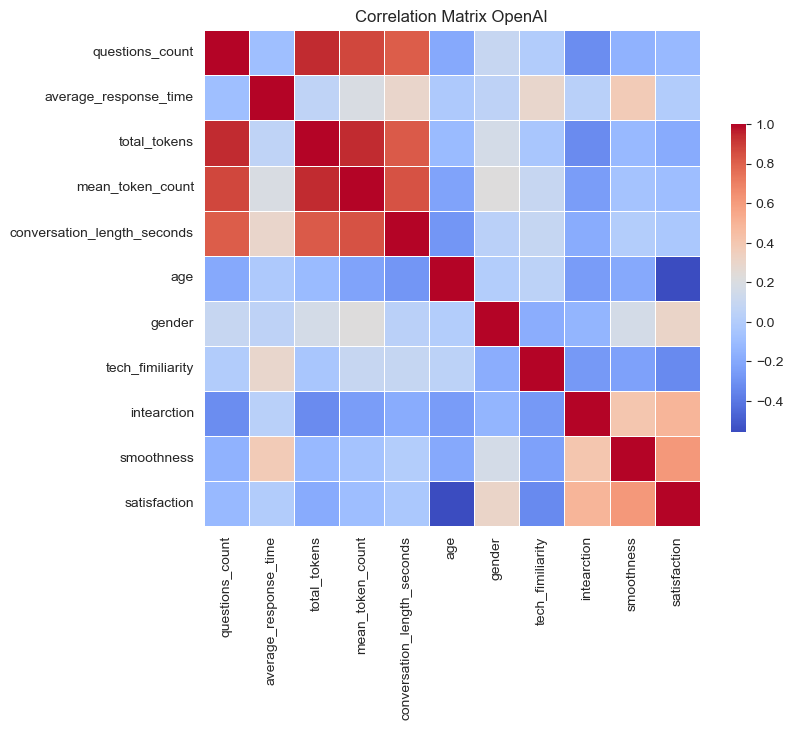

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(8, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix_oai, annot=False, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix OpenAI')

# Show plot
plt.show()


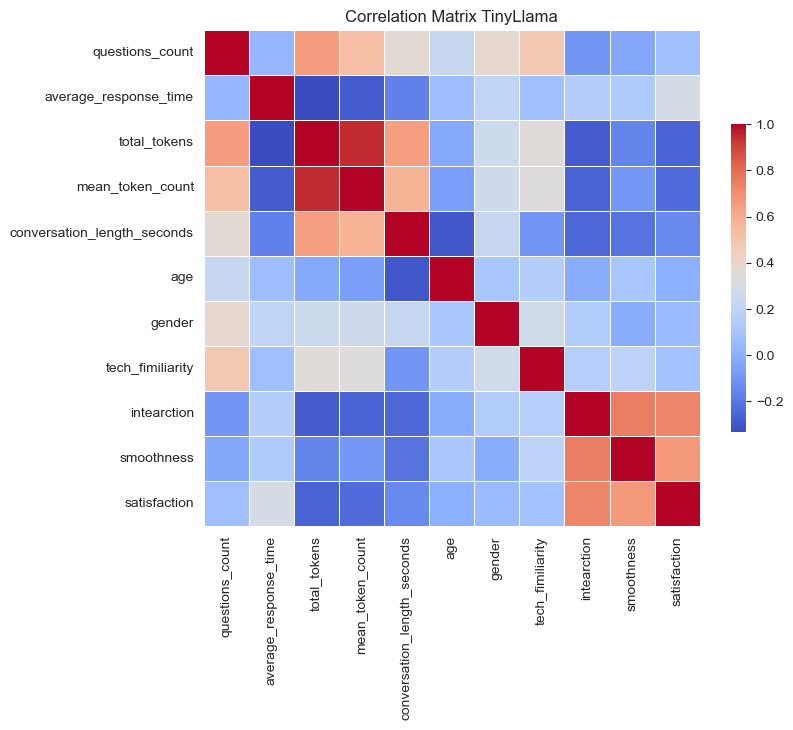

In [19]:
# Set up the matplotlib figure
plt.figure(figsize=(8, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix_tiny, annot=False, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix TinyLlama')

# Show plot
plt.show()


In [20]:
# import pandas as pd
# from scipy.stats import f_oneway
# 
# # Assuming df is your DataFrame and it's already loaded with your data
# 
# # Example of categorizing 'questions_count' into three groups
# # Categorizing 'average_response_time' into three groups
# # Adjust the bin ranges or the method of categorization based on your specific data characteristics
# df_oai_numerical['questions_category'] = pd.cut(df_oai_numerical['average_response_time'], bins=[0, 2, 5, 10, float('inf')], labels=['Very Low', 'Low', 'Medium', 'High'])
# 
# # Grouping 'satisfaction' based on these categories
# grouped_satisfaction = [group['satisfaction'].values for name, group in df_oai_numerical.groupby('questions_category', observed=True)]
# 
# # Perform ANOVA
# f_value, p_value = f_oneway(*grouped_satisfaction)
# print(f"F-value: {f_value}")
# print(f"P-value: {p_value}")


In [21]:
# df_oai_numerical['questions_category']

In [22]:
# f_value, p_value = f_oneway(*grouped_data)
# print(f"F-value: {f_value}")
# print(f"P-value: {p_value}")


In [23]:
# Convert all columns to float, handling errors
df_oai_numerical['conversation_length_seconds']


0      81.258
1     314.596
2     301.390
3     150.858
4     113.463
5     156.452
6     144.263
7     351.825
8     164.026
9     206.477
10     97.283
11    199.534
12     54.649
13    238.421
14    340.224
15    259.924
16    340.181
17    222.552
18    166.666
19    121.560
20    208.958
21    260.224
22    153.167
23    280.888
24    171.300
25    307.844
26    356.756
27     86.489
28    193.824
Name: conversation_length_seconds, dtype: float64

In [24]:
# lets do shapiro test on the distribution of eac numrical cloumn 

from scipy.stats import shapiro

col =[ 'questions_count', 'average_response_time', 'total_tokens', 'mean_token_count', 'conversation_length_seconds']
for column in df_oai_numerical[col]:
    stat, p = shapiro(df_oai_numerical[column])
    print(f"Shapiro-Wilk Test for {column}:")
    print(column)
    print(f"Statistics={stat}, p={p}")
    alpha = 0.05
    if p > alpha:
        print(f"Sample looks Gaussian (fail to reject H0)")
    else:
        print(f"Sample does not look Gaussian (reject H0)")
    print()

Shapiro-Wilk Test for questions_count:
questions_count
Statistics=0.9023616313934326, p=0.011164451949298382
Sample does not look Gaussian (reject H0)

Shapiro-Wilk Test for average_response_time:
average_response_time
Statistics=0.9194327592849731, p=0.02950006164610386
Sample does not look Gaussian (reject H0)

Shapiro-Wilk Test for total_tokens:
total_tokens
Statistics=0.8237303495407104, p=0.00022946820536162704
Sample does not look Gaussian (reject H0)

Shapiro-Wilk Test for mean_token_count:
mean_token_count
Statistics=0.9446592926979065, p=0.13280485570430756
Sample looks Gaussian (fail to reject H0)

Shapiro-Wilk Test for conversation_length_seconds:
conversation_length_seconds
Statistics=0.9563191533088684, p=0.2659722864627838
Sample looks Gaussian (fail to reject H0)


In [25]:
# lets do shapiro test on the distribution of eac numrical cloumn

from scipy.stats import shapiro


col =[ 'questions_count', 'average_response_time', 'total_tokens', 'mean_token_count', 'conversation_length_seconds']

for column in df_tiny_numerical[col]:
    stat, p = shapiro(df_tiny_numerical[column])
    print(f"Shapiro-Wilk Test for {column}:")
    print(column)
    print(f"Statistics={stat}, p={p}")
    alpha = 0.05
    if p > alpha:
        print(f"Sample looks Gaussian (fail to reject H0)")
    else:
        print(f"Sample does not look Gaussian (reject H0)")
    print()
    
    

Shapiro-Wilk Test for questions_count:
questions_count
Statistics=0.8957898020744324, p=0.0056679691188037395
Sample does not look Gaussian (reject H0)

Shapiro-Wilk Test for average_response_time:
average_response_time
Statistics=0.8858163356781006, p=0.0032489497680217028
Sample does not look Gaussian (reject H0)

Shapiro-Wilk Test for total_tokens:
total_tokens
Statistics=0.3861404061317444, p=2.710260627036831e-10
Sample does not look Gaussian (reject H0)

Shapiro-Wilk Test for mean_token_count:
mean_token_count
Statistics=0.5933980941772461, p=4.3270535599049254e-08
Sample does not look Gaussian (reject H0)

Shapiro-Wilk Test for conversation_length_seconds:
conversation_length_seconds
Statistics=0.676008403301239, p=5.241107601250405e-07
Sample does not look Gaussian (reject H0)


In [26]:
# so it seems that the data is not normally distributed lets do Mann-Whitney U test  to benchmark the two datasets df_oai_numerical and df_tiny_numerical 
from scipy.stats import mannwhitneyu


col =[ 'questions_count', 'average_response_time', 'total_tokens', 'mean_token_count', 'conversation_length_seconds']

# lets benchmark the two datasets each on same column
for column in col:
    stat, p = mannwhitneyu(df_oai_numerical[column], df_tiny_numerical[column])
    print(f"Mann-Whitney U Test for {column}:")
    print(f"Statistics={stat}, p={p}")
    alpha = 0.05
    if p > alpha:
        print(f"Same distribution (fail to reject H0)")
    else:
        print(f"Different distribution (reject H0)")
    print()
    
    


Mann-Whitney U Test for questions_count:
Statistics=586.5, p=0.04156166739728789
Different distribution (reject H0)

Mann-Whitney U Test for average_response_time:
Statistics=66.0, p=1.4632349332889201e-08
Different distribution (reject H0)

Mann-Whitney U Test for total_tokens:
Statistics=814.0, p=7.239567488121624e-08
Different distribution (reject H0)

Mann-Whitney U Test for mean_token_count:
Statistics=803.0, p=1.764261641112619e-07
Different distribution (reject H0)

Mann-Whitney U Test for conversation_length_seconds:
Statistics=767.0, p=2.720949439868997e-06
Different distribution (reject H0)


In [27]:
# lets see the Mann-Whitney U test for the smoothness and satisfaction and Interaction  

col = ['smoothness', 'satisfaction', 'intearction']

for column in col:
    stat, p = mannwhitneyu(df_oai[column], df_tiny[column])
    print(f"Mann-Whitney U Test for {column}:")
    print(f"Statistics={stat}, p={p}")
    alpha = 0.05
    if p > alpha:
        print(f"Same distribution (fail to reject H0)")
    else:
        print(f"Different distribution (reject H0)")
    print()

Mann-Whitney U Test for smoothness:
Statistics=655.0, p=0.0010413405925744012
Different distribution (reject H0)

Mann-Whitney U Test for satisfaction:
Statistics=661.0, p=0.0011212028568830976
Different distribution (reject H0)

Mann-Whitney U Test for intearction:
Statistics=650.0, p=0.0018937547265224753
Different distribution (reject H0)


In [28]:
import pandas as pd

# Assuming both dataframes have the same structure
df_oai_numerical['Group'] = 'OpenAI'
df_tiny_numerical['Group'] = 'TinyLlama'

# Combine the datasets
df_combined = pd.concat([df_oai_numerical, df_tiny_numerical], ignore_index=True)


In [29]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# for each column for normality
# Normality check for each group
for column in df_oai_numerical.columns:
    if column == 'Group':
        continue

    print(stats.shapiro(df_combined[df_combined['Group'] == 'OpenAI'][column]), 'of column', column, 'OpenAI')
    print(stats.shapiro(df_combined[df_combined['Group'] == 'TinyLlama'][column]), 'of column', column , 'TinyLlama')
# Homogeneity of variances for each column
for column in df_combined.columns:
    if column == 'Group':
        continue

    print(stats.levene(df_combined[df_combined['Group'] == 'OpenAI'][column],df_combined[df_combined['Group'] == 'TinyLlama'][column]), 'of column', column)
    

ShapiroResult(statistic=0.9023616313934326, pvalue=0.011164451949298382) of column questions_count OpenAI
ShapiroResult(statistic=0.8957898020744324, pvalue=0.0056679691188037395) of column questions_count TinyLlama
ShapiroResult(statistic=0.9194327592849731, pvalue=0.02950006164610386) of column average_response_time OpenAI
ShapiroResult(statistic=0.8858163356781006, pvalue=0.0032489497680217028) of column average_response_time TinyLlama
ShapiroResult(statistic=0.8237303495407104, pvalue=0.00022946820536162704) of column total_tokens OpenAI
ShapiroResult(statistic=0.3861404061317444, pvalue=2.710260627036831e-10) of column total_tokens TinyLlama
ShapiroResult(statistic=0.9446592926979065, pvalue=0.13280485570430756) of column mean_token_count OpenAI
ShapiroResult(statistic=0.5933980941772461, pvalue=4.3270535599049254e-08) of column mean_token_count TinyLlama
ShapiroResult(statistic=0.9563191533088684, pvalue=0.2659722864627838) of column conversation_length_seconds OpenAI
ShapiroResu

In [30]:
# lets do the ANOVA test on the columns according to the group 
# ANOVA test for each column

for column in df_combined.columns:
    if column == 'Group':
        continue

    model = ols(f'{column} ~ Group', data=df_combined).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    # print aov_table for each column
    print(aov_table , '    of column', column)
    

              sum_sq    df         F    PR(>F)
Group      51.827660   1.0  4.718219  0.033946
Residual  637.105673  58.0       NaN       NaN     of column questions_count
              sum_sq    df          F        PR(>F)
Group     412.435628   1.0  85.420109  5.294342e-13
Residual  280.042564  58.0        NaN           NaN     of column average_response_time
                sum_sq    df         F    PR(>F)
Group     5.486105e+07   1.0  16.08106  0.000176
Residual  1.978688e+08  58.0       NaN       NaN     of column total_tokens
                 sum_sq    df          F    PR(>F)
Group     274341.546174   1.0  25.325228  0.000005
Residual  628298.766825  58.0        NaN       NaN     of column mean_token_count
                 sum_sq    df          F        PR(>F)
Group     302793.910083   1.0  30.352454  8.640449e-07
Residual  578603.842250  58.0        NaN           NaN     of column conversation_length_seconds
               sum_sq    df         F    PR(>F)
Group       49.135780   

In [31]:
df_combined.columns

Index(['questions_count', 'average_response_time', 'total_tokens',
       'mean_token_count', 'conversation_length_seconds', 'age', 'gender',
       'tech_fimiliarity', 'intearction', 'smoothness', 'satisfaction',
       'Group'],
      dtype='object')

In [32]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Assuming df_combined is your DataFrame and 'Group' column distinguishes between OpenAI and TinyLlama
columns_to_analyze = ['questions_count', 'average_response_time', 'total_tokens', 
                      'mean_token_count', 'conversation_length_seconds', 'tech_fimiliarity', 
                      'intearction', 'smoothness', 'satisfaction']

results = pd.DataFrame()  # DataFrame to hold results

# Adjusted loop to only analyze specified columns
for column in columns_to_analyze:
    if column in df_combined.columns:
        # Perform ANOVA first to see if there's a significant effect
        model = ols(f'{column} ~ C(Group)', data=df_combined).fit()
        anova_results = sm.stats.anova_lm(model, typ=2)

        if anova_results.loc['C(Group)', 'PR(>F)'] < 0.05:  # Check if the ANOVA p-value is less than 0.05
            # Perform Tukey HSD
            posthoc = pairwise_tukeyhsd(endog=df_combined[column], groups=df_combined['Group'], alpha=0.05)
            results = pd.concat([results, pd.DataFrame({
                'Metric': column,
                'F-stat': anova_results.loc['C(Group)', 'F'],
                'p-value': anova_results.loc['C(Group)', 'PR(>F)'],
                'Comparison Results': [posthoc.summary()]
            })])

# Print the overall results
print(results)

# Optionally, save the results to a CSV file
results.to_csv('tukey_hsd_results.csv', index=False)

# Plotting
for index, result in results.iterrows():
    print(f"Tukey HSD results for {result['Metric']}:")
    print(result['Comparison Results'])

# Additional: Calculate and display mean values for each group for each metric
mean_results = df_combined.groupby('Group')[columns_to_analyze].mean()
print(mean_results)


                        Metric     F-stat       p-value  \
0              questions_count   4.718219  3.394562e-02   
0        average_response_time  85.420109  5.294342e-13   
0                 total_tokens  16.081060  1.757336e-04   
0             mean_token_count  25.325228  4.995586e-06   
0  conversation_length_seconds  30.352454  8.640449e-07   
0             tech_fimiliarity  19.439378  4.555585e-05   
0                  intearction  11.654990  1.174080e-03   
0                   smoothness  11.276185  1.391485e-03   
0                 satisfaction  13.719427  4.751720e-04   

                                  Comparison Results  
0  [[group1, group2, meandiff, p-adj, lower, uppe...  
0  [[group1, group2, meandiff, p-adj, lower, uppe...  
0  [[group1, group2, meandiff, p-adj, lower, uppe...  
0  [[group1, group2, meandiff, p-adj, lower, uppe...  
0  [[group1, group2, meandiff, p-adj, lower, uppe...  
0  [[group1, group2, meandiff, p-adj, lower, uppe...  
0  [[group1, group2, mea

C:\Users\Gebruiker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Gebruiker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


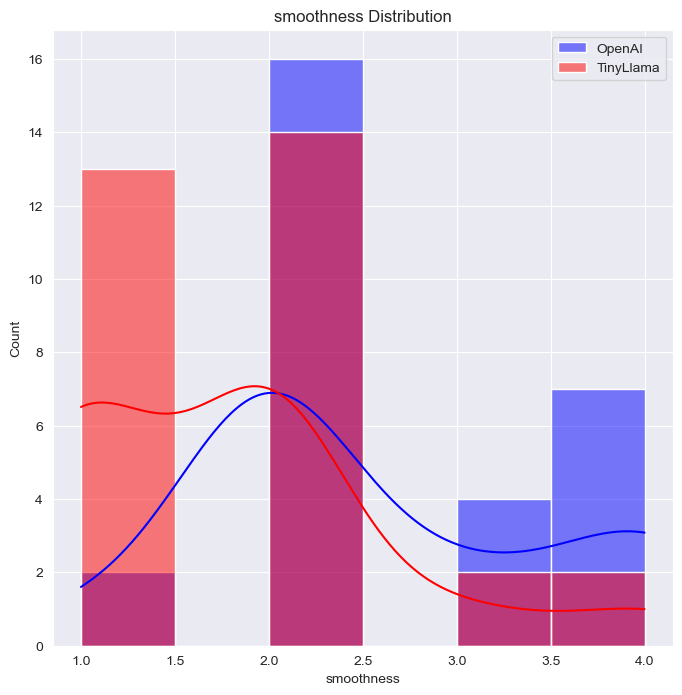

C:\Users\Gebruiker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Gebruiker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


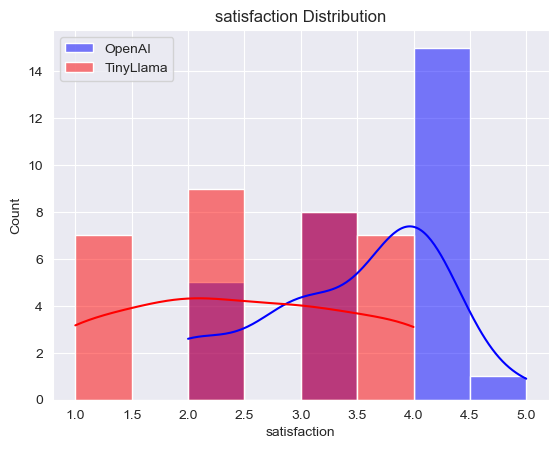

C:\Users\Gebruiker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Gebruiker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


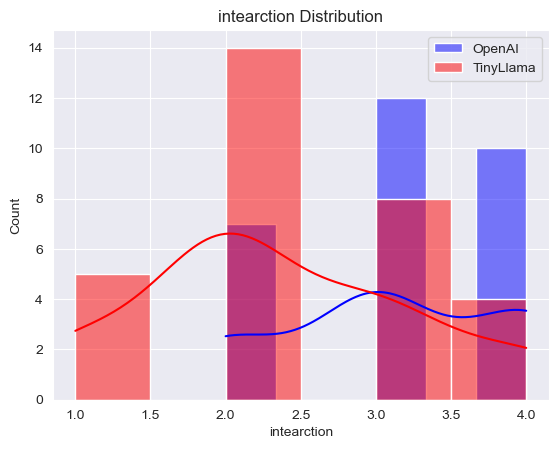

C:\Users\Gebruiker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Gebruiker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


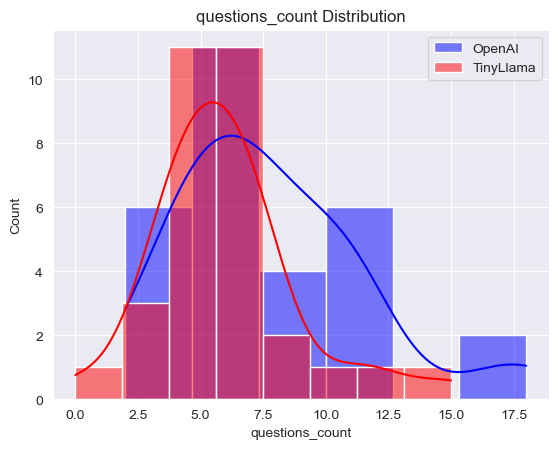

C:\Users\Gebruiker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Gebruiker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


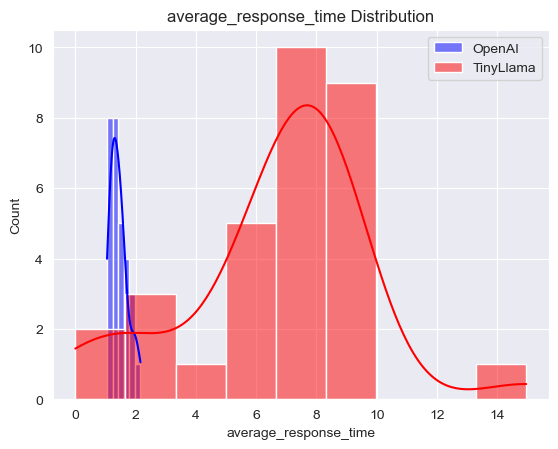

C:\Users\Gebruiker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Gebruiker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


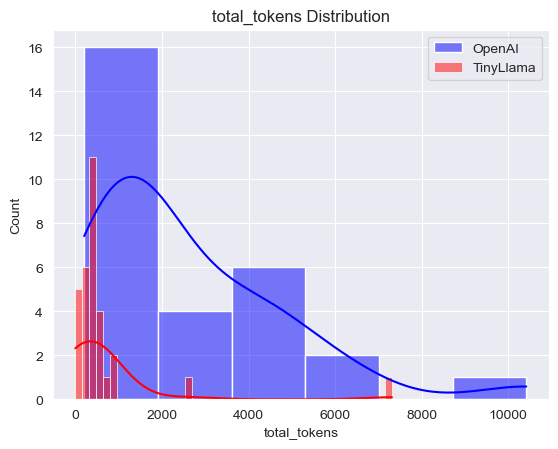

C:\Users\Gebruiker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Gebruiker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


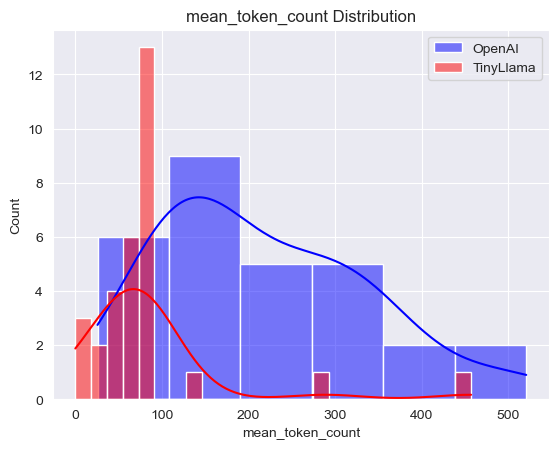

C:\Users\Gebruiker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Gebruiker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


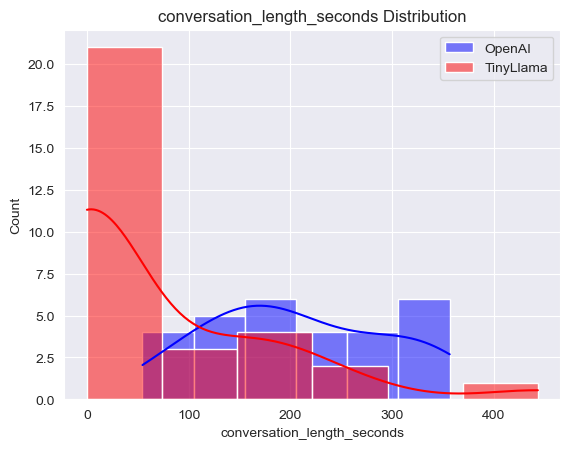

In [33]:
# lets compare the two groups on the satisfaction and smoothness and intration distribution of both datasets
import seaborn as sns
import matplotlib.pyplot as plt

col =[ 'smoothness', 'satisfaction', 'intearction', 
      'questions_count', 'average_response_time', 'total_tokens', 'mean_token_count', 'conversation_length_seconds']
# Set up the matplotlib figure
plt.figure(figsize=(8, 8))

for column in col:
    sns.histplot(df_oai[column], kde=True, label='OpenAI', color='blue', alpha=0.5)
    sns.histplot(df_tiny[column], kde=True, label='TinyLlama', color='red', alpha=0.5)
    plt.title(f'{column} Distribution')
    plt.legend()
    plt.show()

In [34]:
# lets analyses the RBK data within suervy 

suervy['type'].value_counts()

type
RIK             31
Gpt 3.5         22
Gpt 4o          15
Local llama     13
local llama     11
local llama      6
Gpt 3.5          1
Local llama      1
Name: count, dtype: int64

In [35]:
# lets see the distribution of the RIK 

RIK = suervy[suervy['type'] == 'RIK'] 

In [36]:
RIK['satisfaction'] = RIK['satisfaction'].apply(convert_to_scale)
RIK['smoothness'] = RIK['smoothness'].apply(convert_smoothness)


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_5476\3135527095.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RIK['satisfaction'] = RIK['satisfaction'].apply(convert_to_scale)
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_5476\3135527095.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RIK['smoothness'] = RIK['smoothness'].apply(convert_smoothness)


In [37]:
RIK

,time,age,gender,type_of_person,education,tech_fimiliarity,intearction,smoothness,satisfaction,comment,ID,type
69,2024-05-28 13:55:19.346,21,Male,Student,Communication,5,1,4,5,NaN,69.0,RIK
70,2024-05-28 13:55:41.266,21,Female,Student,Music marketing,2,2,4,4,NaN,70.0,RIK
71,2024-05-28 13:55:55.480,24,Female,Student,music marketing and management,1,1,5,5,NaN,71.0,RIK
72,2024-05-28 13:56:06.768,22,Female,Student,Marketing,2,3,5,5,NaN,72.0,RIK
73,2024-05-28 13:57:28.175,21,Male,Student,ICT,5,2,2,2,NaN,73.0,RIK
74,2024-05-28 14:01:34.774,24,Male,Student,IT,3,4,4,4,NaN,74.0,RIK
75,2024-05-28 14:27:34.690,23,Male,Student,communication and media,2,4,3,3,NaN,75.0,RIK
76,2024-05-28 14:29:41.508,21,Female,Student,International Advertising,2,3,4,5,NaN,76.0,RIK
77,2024-05-28 14:43:42.050,22,Male,Student,Business administration,2,4,4,5,NaN,77.0,RIK
78,2024-05-28 14:44:01.034,22,Male,Student,Business,5,2,4,4,NaN,78.0,RIK


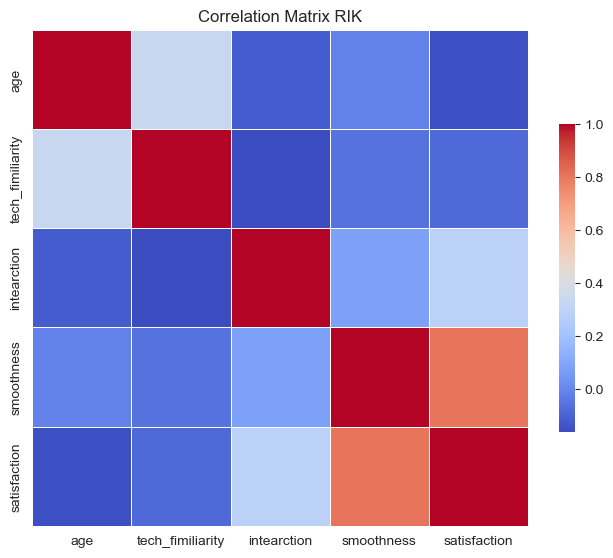

In [38]:
# lets do the correlation analysis on the RIK data
RIK_numerical = RIK.select_dtypes(include=['number'])
 
# lets just dont take the ID column
RIK_numerical = RIK_numerical.drop(columns=['ID'])


correlation_matrix_RIK = RIK_numerical.corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix_RIK, annot=False, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix RIK')
plt.show()

In [39]:
# lets see the distribution of the RIK

col = ['smoothness', 'satisfaction', 'intearction']

for column in col:
    stat, p = shapiro(RIK[column])
    print(f"Shapiro-Wilk Test for {column}:")
    print(column)
    print(f"Statistics={stat}, p={p}")
    alpha = 0.05
    if p > alpha:
        print(f"Sample looks Gaussian (fail to reject H0)")
    else:
        print(f"Sample does not look Gaussian (reject H0)")
    print()
    

Shapiro-Wilk Test for smoothness:
smoothness
Statistics=0.8904086947441101, p=0.004188491031527519
Sample does not look Gaussian (reject H0)

Shapiro-Wilk Test for satisfaction:
satisfaction
Statistics=0.8328599333763123, p=0.00022322127188090235
Sample does not look Gaussian (reject H0)

Shapiro-Wilk Test for intearction:
intearction
Statistics=0.8850134015083313, p=0.0031090101692825556
Sample does not look Gaussian (reject H0)


C:\Users\Gebruiker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Gebruiker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


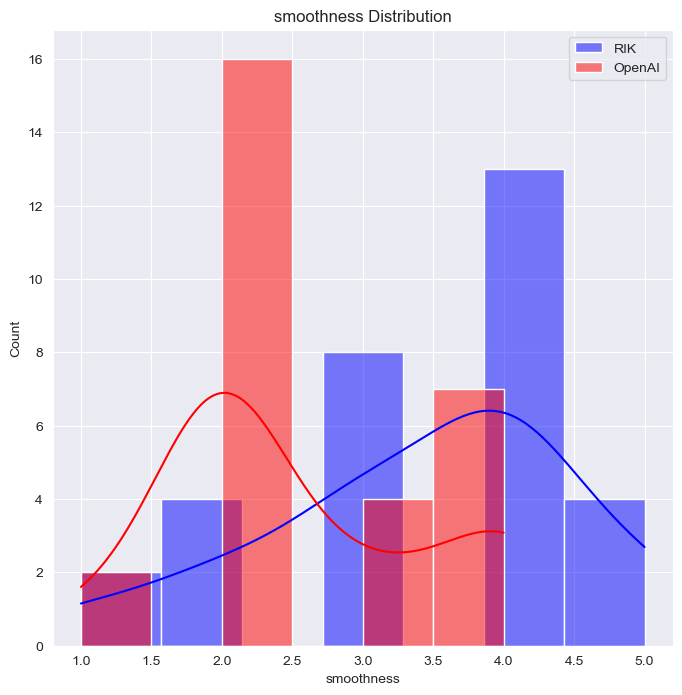

C:\Users\Gebruiker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Gebruiker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


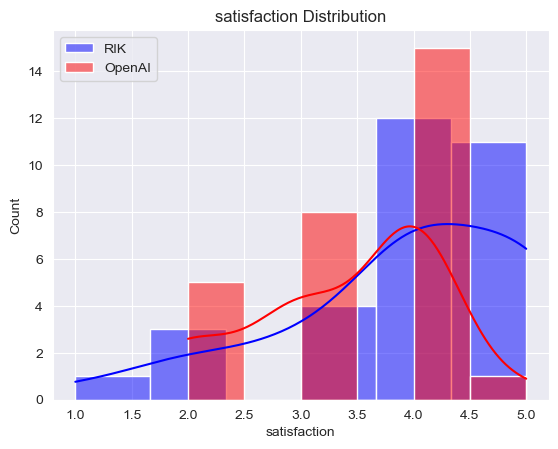

C:\Users\Gebruiker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Gebruiker\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


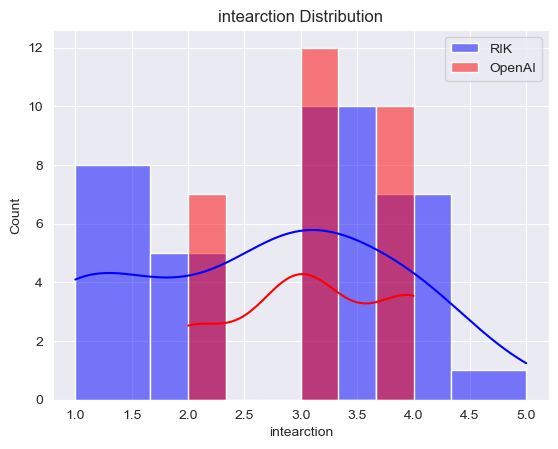

In [40]:
# lets see the distribution of smoothness and satisfaction and Interaction 

col = ['smoothness', 'satisfaction', 'intearction']
plt.figure(figsize=(8, 8))
for column in col:
    sns.histplot(RIK[column], kde=True, label='RIK', color='blue', alpha=0.5)
    sns.histplot(df_oai[column], kde=True, label='OpenAI', color='red', alpha=0.5)
    plt.title(f'{column} Distribution')
    plt.legend()
    plt.show()
    
    

In [41]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Assuming df_combined is your DataFrame and 'Group' column distinguishes between OpenAI and TinyLlama
columns_to_analyze = ['intearction', 'smoothness', 'satisfaction']
RIK_numerical['Group'] = 'RIK'
df_combined = pd.concat([df_oai_numerical, RIK_numerical], ignore_index=True)

results = pd.DataFrame()  # DataFrame to hold results

# Adjusted loop to only analyze specified columns
for column in columns_to_analyze:
    if column in df_combined.columns:
        # Perform ANOVA first to see if there's a significant effect
        model = ols(f'{column} ~ C(Group)', data=df_combined).fit()
        anova_results = sm.stats.anova_lm(model, typ=2)

        if anova_results.loc['C(Group)', 'PR(>F)'] < 0.05:  # Check if the ANOVA p-value is less than 0.05
            # Perform Tukey HSD
            posthoc = pairwise_tukeyhsd(endog=df_combined[column], groups=df_combined['Group'], alpha=0.05)
            results = pd.concat([results, pd.DataFrame({
                'Metric': column,
                'F-stat': anova_results.loc['C(Group)', 'F'],
                'p-value': anova_results.loc['C(Group)', 'PR(>F)'],
                'Comparison Results': [posthoc.summary()]
            })])

# Print the overall results
print(results)

# Optionally, save the results to a CSV file
results.to_csv('tukey_hsd_results.csv', index=False)

# Plotting
for index, result in results.iterrows():
    print(f"Tukey HSD results for {result['Metric']}:")
    print(result['Comparison Results'])

# Additional: Calculate and display mean values for each group for each metric
mean_results = df_combined.groupby('Group')[columns_to_analyze].mean()
print(mean_results)


         Metric     F-stat   p-value  \
0    smoothness  10.773796  0.001747   
0  satisfaction   4.307718  0.042384   

                                  Comparison Results  
0  [[group1, group2, meandiff, p-adj, lower, uppe...  
0  [[group1, group2, meandiff, p-adj, lower, uppe...  
Tukey HSD results for smoothness:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
OpenAI    RIK   0.8676 0.0017 0.3385 1.3967   True
--------------------------------------------------
Tukey HSD results for satisfaction:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
OpenAI    RIK   0.5217 0.0424 0.0185 1.0248   True
--------------------------------------------------
        intearction  smoothness  satisfaction
Group                                        
OpenAI     3.103448    2.551724      3.4

In [42]:
# Print column names and unique groups to check
print(df_combined.columns)
print(df_combined['Group'].unique())


Index(['questions_count', 'average_response_time', 'total_tokens',
       'mean_token_count', 'conversation_length_seconds', 'age', 'gender',
       'tech_fimiliarity', 'intearction', 'smoothness', 'satisfaction',
       'Group'],
      dtype='object')
['OpenAI' 'RIK']
